   **Kinship detection with One-shot learning using Siamese Network**



https://towardsdatascience.com/deep-neural-networks-for-kinship-prediction-using-face-photos-f2ad9ab53834

https://www.coursera.org/lecture/convolutional-neural-networks/siamese-network-bjhmj

https://towardsdatascience.com/one-shot-learning-face-recognition-using-siamese-neural-network-a13dcf739e

** What is one-shot learning?**

One-shot learning is an object categorization problem, found mostly in computer vision. Whereas most machine learning based object categorization algorithms require training on hundreds or thousands of samples/images and very large datasets, one-shot learning aims to learn information about object categories from one, or only a few, training samples/images.

**What is Siamese Network??**

Siamese network is an artificial neural network that use the same weights while working in tandem on two different input vectors to compute comparable output vectors.
Often one of the output vectors is precomputed, thus forming a baseline against which the other output vector is compared. This is similar to comparing fingerprints or more technical as a distance function for Locality-sensitive hashing.

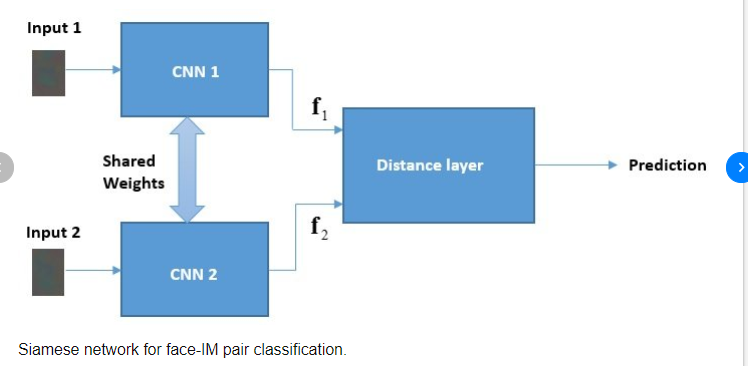![](http://)

**Data Overview**

In this competition, you will predict if two people share a kinship relationship or not based on their facial images. The data is provided by Families In the Wild (FIW), the largest and most comprehensive image database for automatic kinship recognition.

FIW's dataset is obtained from publicly available images from celebrities. For more information about their labeling process, please visit their database page.

File descriptions

train-faces.zip - the training set is divided in Families (F0123), then individuals (MIDx). Images in the same MIDx folder belong to the same person. Images in the same F0123 folder belong to the same family.

train.csv - training labels. Remember, not every individual in a family shares a kinship relationship. For example, a mother and father are kin to their children, but not to each other.
test-faces.zip - the test set contains face images of unknown individuals

sample_submission.csv - a sample submission file in the correct format. The column img_pair describes the pair of images, i.e., abcdef-ghijkl means the pair of images abcdef.jpg and ghijkl.jpg. Your goal is to predict if each pair of images in test-faces are related or not, where 1 means related and 0 means unrelated.

https://www.kaggle.com/c/recognizing-faces-in-the-wild

1. **Exploratory Data Analysis**

In [45]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import random
import base64
from PIL import Image
from io import BytesIO
from IPython.display import HTML
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 9999
pd.options.display.float_format = '{:20, .2f}'.format



In [46]:
print(os.listdir("../input"))

['train', 'test', 'train_relationships.csv', 'sample_submission.csv']


The input folder consist of the above files.


In [47]:
train_df = pd.read_csv('../input/train_relationships.csv')
train_images =  Path('../input/train/')
test_images = Path('.../input/test/')
train_df.head()

p1          p2
0  F0002/MID1  F0002/MID3
1  F0002/MID2  F0002/MID3
2  F0005/MID1  F0005/MID2
3  F0005/MID3  F0005/MID2
4  F0009/MID1  F0009/MID4

In [48]:
train_df.shape

(3598, 2)

There are total 3598 relations in the csv file

In [49]:
train_df.shape #Ignoring missing directories

(3598, 2)

**Displaying the images of kins **

In [50]:
pd.set_option('display.max_colwidth', -1)

def get_thumbnail(path):
    if path and os.path.exists(path):
        i = Image.open(path)
        i.thumbnail((150, 150), Image.LANCZOS)
        return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

def add_image_path(x):
    image_path = '../input/train/' + x
    if os.path.exists(image_path):
        path = os.path.join(image_path, os.listdir(image_path)[0])
        return path

In [51]:
kin_df = train_df.sample(50)

In [52]:
kin_df['p1_path'] = kin_df.p1.apply(lambda x: add_image_path(x))
kin_df['p2_path'] = kin_df.p2.apply(lambda x: add_image_path(x))
kin_df['p1_thumb'] = kin_df.p1_path.map(lambda f: get_thumbnail(f))
kin_df['p2_thumb'] = kin_df.p2_path.map(lambda f: get_thumbnail(f))
kin_df.head()

p1          p2                                     p1_path  \
2032  F0599/MID2  F0599/MID3  ../input/train/F0599/MID2/P10732_face1.jpg   
3248  F0893/MID3  F0893/MID4  ../input/train/F0893/MID3/P09423_face2.jpg   
947   F0264/MID1  F0264/MID5  ../input/train/F0264/MID1/P02809_face1.jpg   
1232  F0357/MID6  F0357/MID9  ../input/train/F0357/MID6/P03785_face2.jpg   
1913  F0556/MID3  F0556/MID2  ../input/train/F0556/MID3/P05837_face2.jpg   

                                         p2_path  \
2032  ../input/train/F0599/MID3/P10738_face1.jpg   
3248  ../input/train/F0893/MID4/P09423_face4.jpg   
947   None                                         
1232  ../input/train/F0357/MID9/P03790_face1.jpg   
1913  ../input/train/F0556/MID2/P05840_face1.jpg   

                                                                               p1_thumb  \
2032  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=150x150 at 0x7F16790981D0>   
3248  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=150x150 at 0x7F1679098128>   
947   <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=150x150 at 0x7F1679098080>   
1232  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=150x150 at 0x7F1679080F98>   
1913  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=150x150 at 0x7F1679080EF0>   

                                                                               p2_thumb  
2032  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=150x150 at 0x7F11CA879160>  
3248  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=150x150 at 0x7F11CA879FD0>  
947   None                                                                               
1232  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=150x150 at 0x7F11CA879F60>  
1913  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=150x150 at 0x7F11CA879E48>


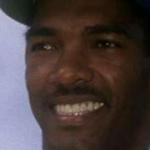
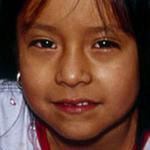
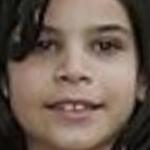
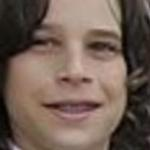
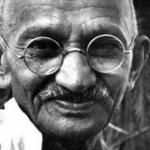
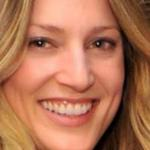
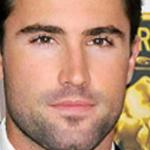
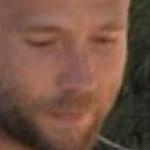
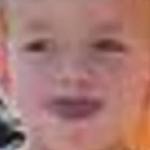
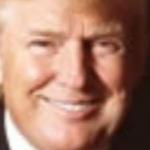
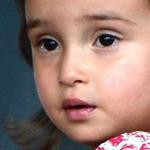
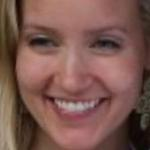
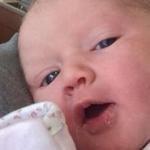
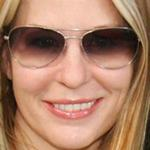
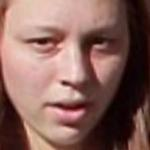
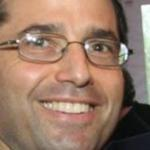
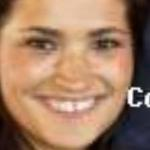
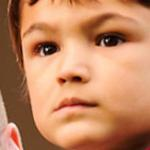
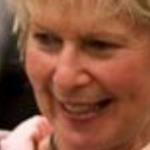
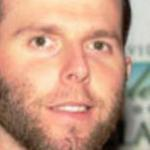
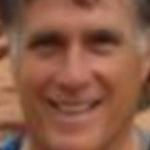
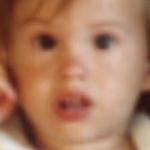
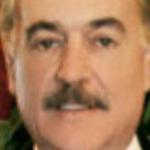
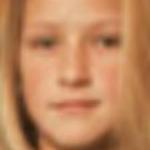
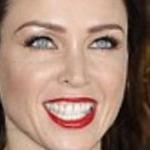
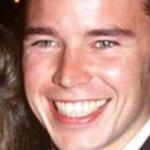
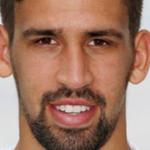
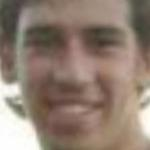
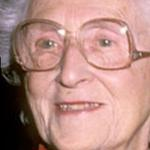
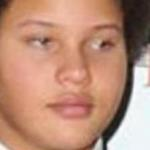
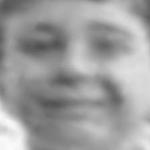
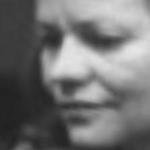
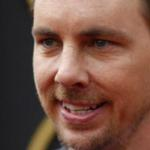
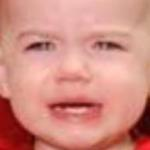
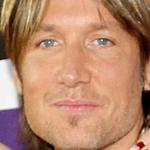
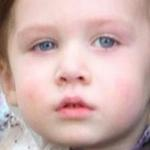
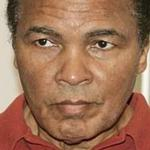
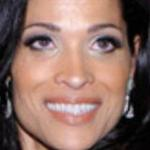
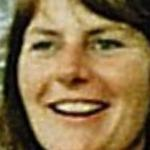
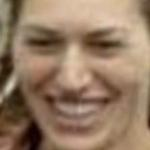
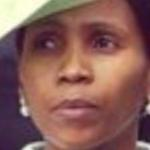
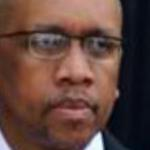
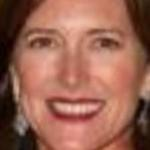
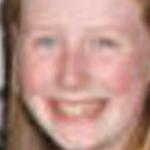
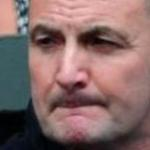
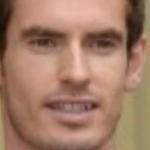
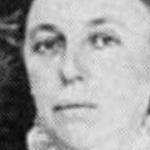
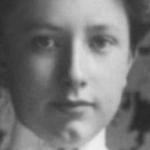
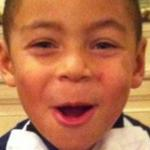
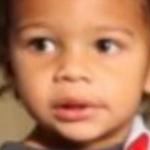
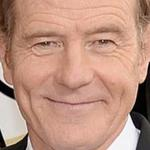
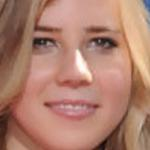
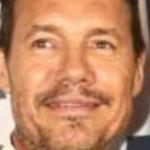
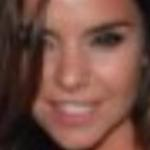
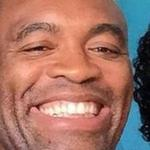
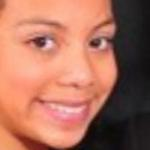
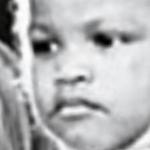
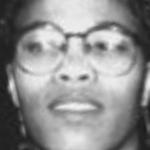
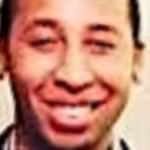
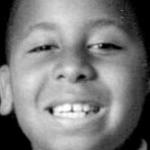
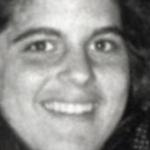
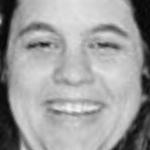
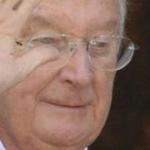
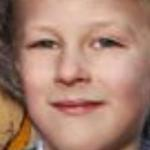
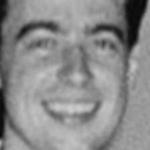
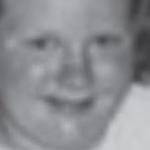
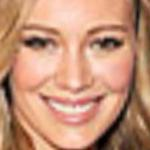
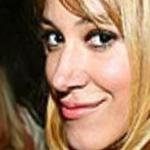
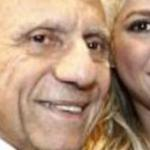
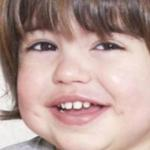
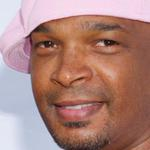
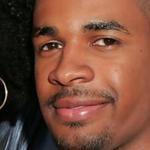
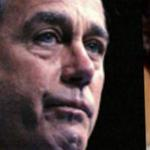
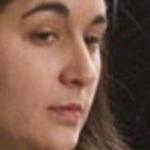
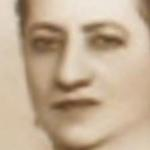
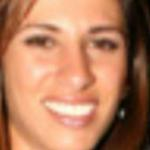
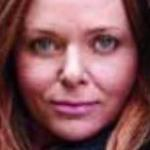
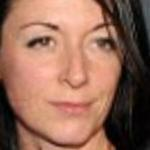
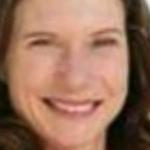
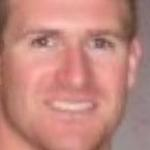
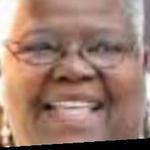
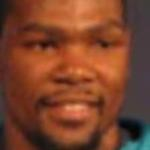
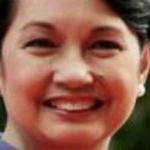
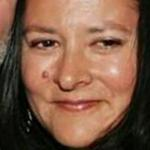
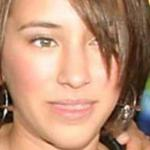
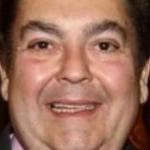
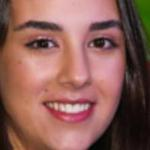
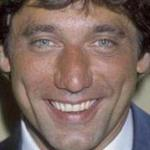
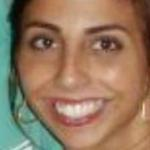
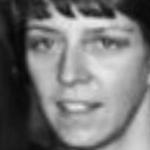
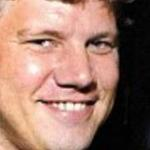
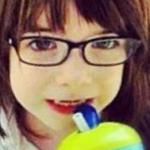
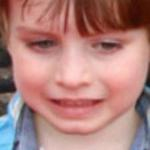
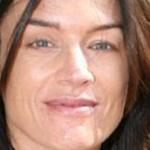
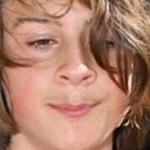
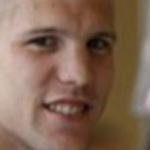
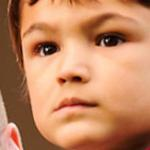

In [53]:
HTML(kin_df[['p1', 'p2', 'p1_thumb', 'p2_thumb']].to_html(formatters={'p1_thumb': image_formatter, 'p2_thumb': image_formatter}, escape=False))

 Function that displays images in a subplot

Looks like there are some empty folders with no matches..

In [54]:
missing_folders = []
temp_list = list(train_df.p1)+list(train_df.p2)
all_list = list(set(temp_list))
all_list.sort()
for i in all_list:
    if(os.path.exists(train_images/i)==False):
        #If no such directory exists
        missing_folders.append(i)
    
print("Number of missing images-relations in trian folder",len(missing_folders))

train_df = train_df[~train_df["p1"].isin(missing_folders)]
train_df = train_df[~train_df["p2"].isin(missing_folders)]

Number of missing images-relations in trian folder 96



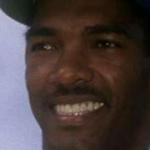
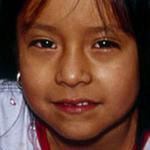
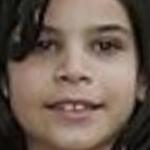
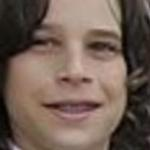
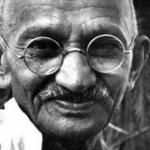
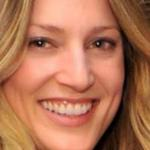
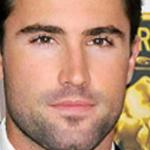
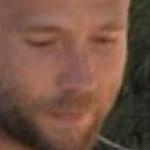
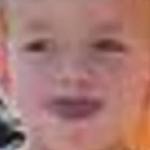
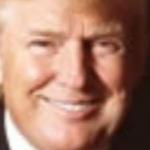
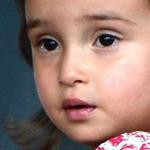
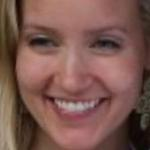
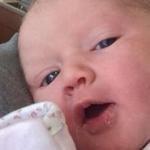
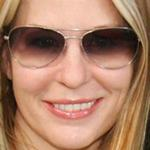
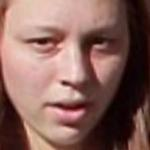
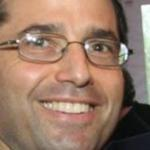
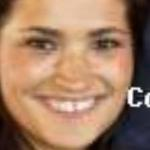
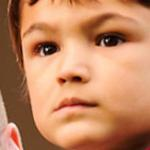
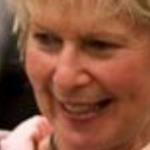
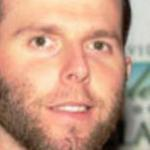
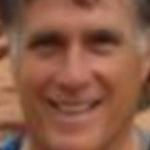
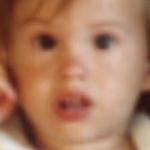
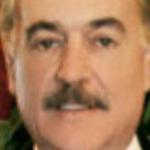
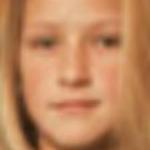
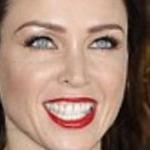
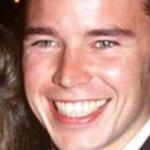
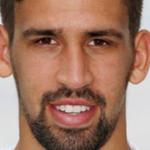
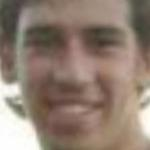
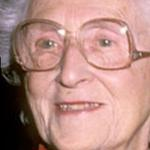
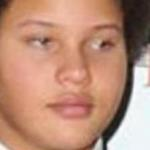
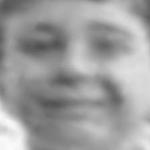
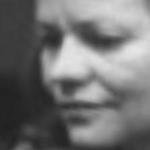
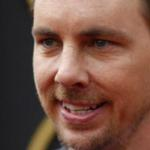
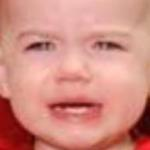
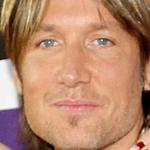
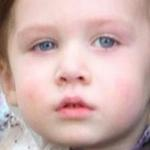
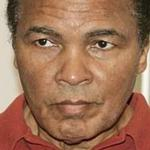
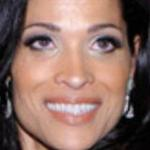
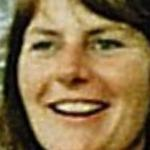
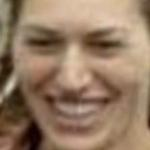
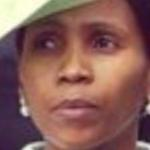
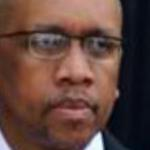
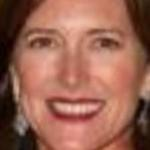
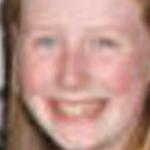
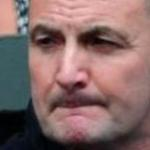
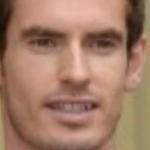
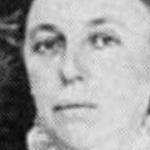
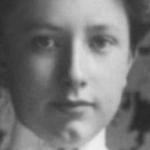
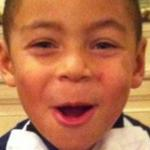
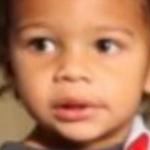
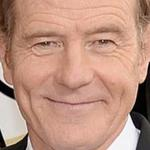
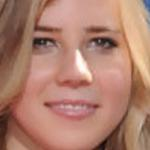
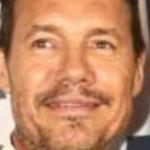
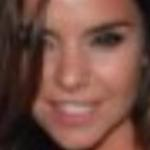
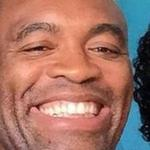
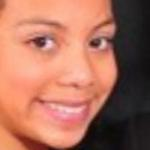
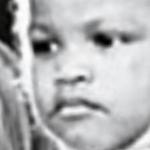
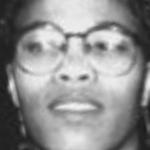
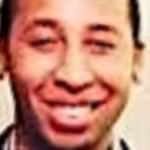
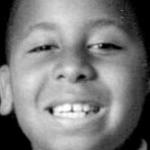
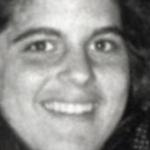
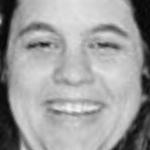
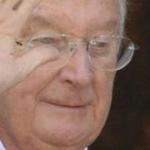
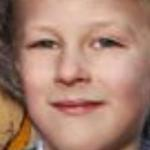
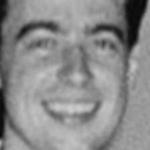
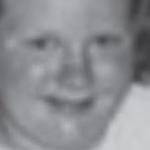
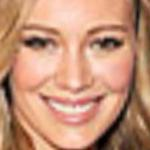
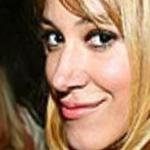
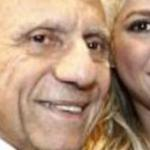
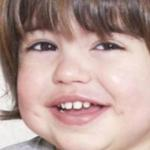
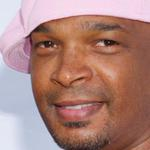
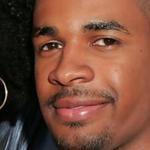
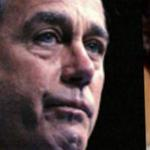
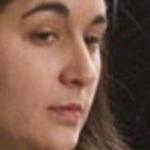
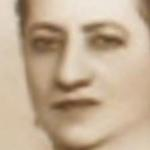
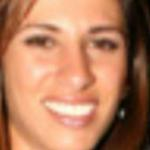
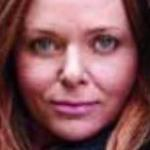
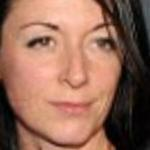
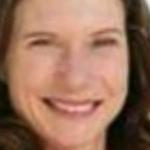
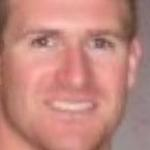
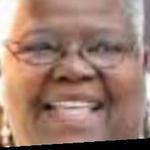
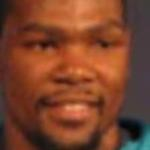
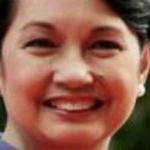
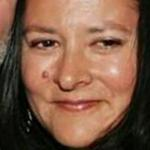
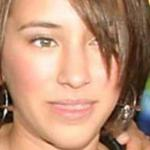
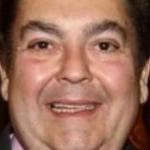
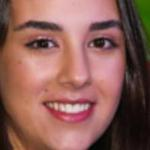
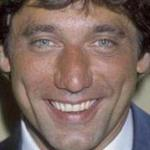
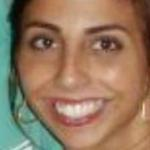
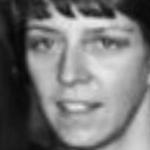
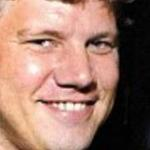
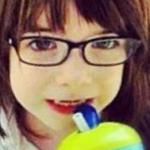
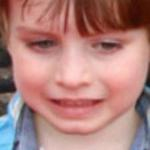
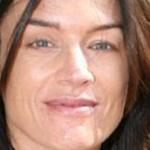
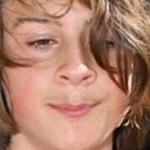
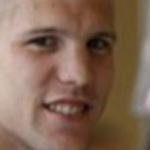
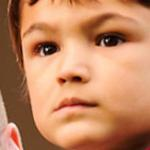

In [55]:
HTML(kin_df[['p1', 'p2', 'p1_thumb', 'p2_thumb']].to_html(formatters={'p1_thumb': image_formatter, 'p2_thumb': image_formatter}, escape=False))

In [56]:
temp_list = list(train_df.p1) + list(train_df.p2)
all_folders = list(set(temp_list))
all_folders.sort()

In [57]:
#Calculate the maximum number of possible images in the folder for the next function
max_images = 0
for i in all_folders:
    img_list = os.listdir(train_images / i)
    if(len(img_list)>max_images):
        max_images = len(img_list)
        
print(max_images)

95


Show Image Function

Using a nx10 subplot to display the images based on the number of images in the folder. If the number of Images is 45 then it will create a 5x10 subplot. If the number of images is less than 10, we default to creating a 2x5 subplot

In [58]:
def show_img(n):
    try:
        n = int(n)
        img_list = os.listdir(train_images / all_folders[n])
        num_images = len(img_list)
        print(num_images)
        if(num_images<=10):
            fig,ax = plt.subplots(2,5, figsize=(20,10))
            print(ax.shape)
            for i in range(len(img_list)):
                with open(train_images / all_folders[n] / img_list[i] ,'rb') as f:
                    img = Image.open(f)
                    ax[i//5][i%5].imshow(img)
            fig.show()

        else:
            fig,ax = plt.subplots((-(-num_images//10)),10, figsize=(40,10))
            print(ax.shape)
            for i in range(len(img_list)):
                with open(train_images / all_folders[n] / img_list[i] ,'rb') as f:
                    img = Image.open(f)
                    ax[i//10][i%10].imshow(img)
            fig.show()
    except ValueError:
        n = all_folders.index(n)
        img_list = os.listdir(train_images / all_folders[n])
        num_images = len(img_list)
        print(num_images)
        if(num_images<=10):
            fig,ax = plt.subplots(2,5, figsize=(20,10))
            print(ax.shape)
            for i in range(len(img_list)):
                with open(train_images / all_folders[n] / img_list[i] ,'rb') as f:
                    img = Image.open(f)
                    ax[i//5][i%5].imshow(img)
            fig.show()

        else:
            fig,ax = plt.subplots((-(-num_images//10)),10, figsize=(40,10))
            print(ax.shape)
            for i in range(len(img_list)):
                with open(train_images / all_folders[n] / img_list[i] ,'rb') as f:
                    img = Image.open(f)
                    ax[i//10][i%10].imshow(img)
            fig.show()

10
(2, 5)


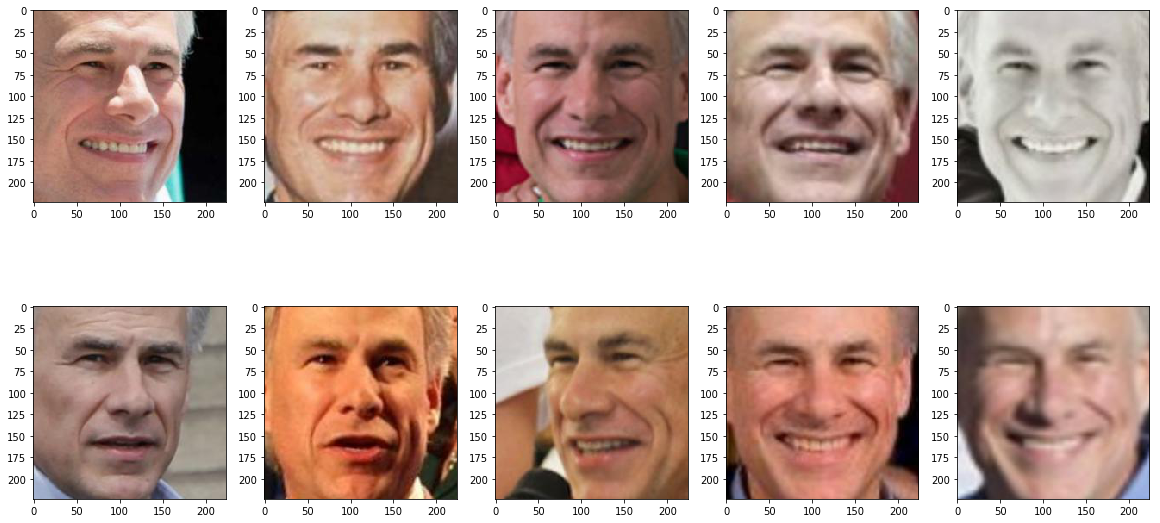

In [59]:
show_img('F0002/MID1')

41
(5, 10)


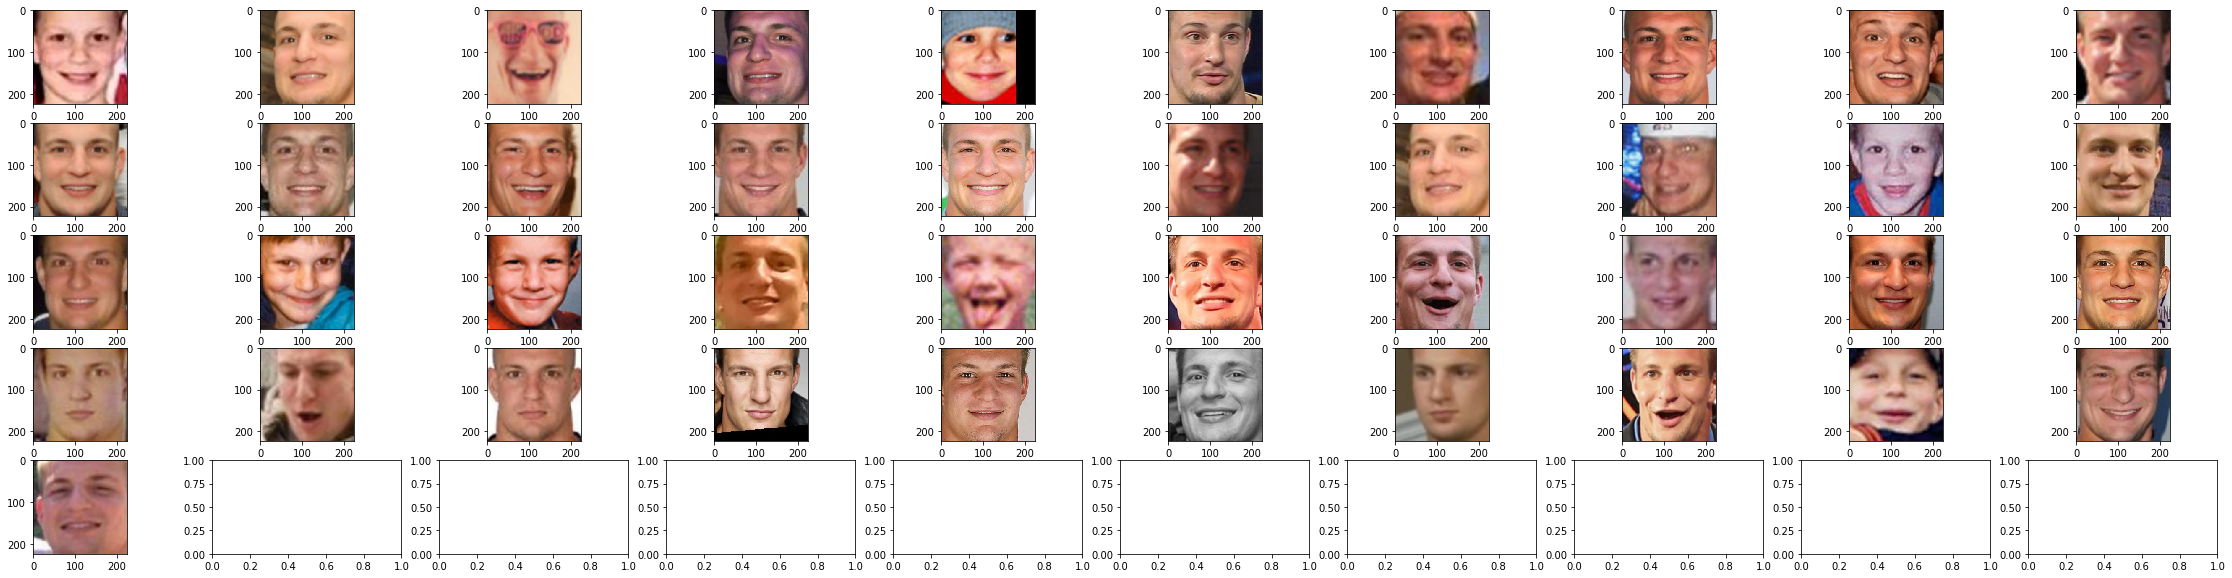

In [60]:
show_img('F0009/MID1')

25
(3, 10)


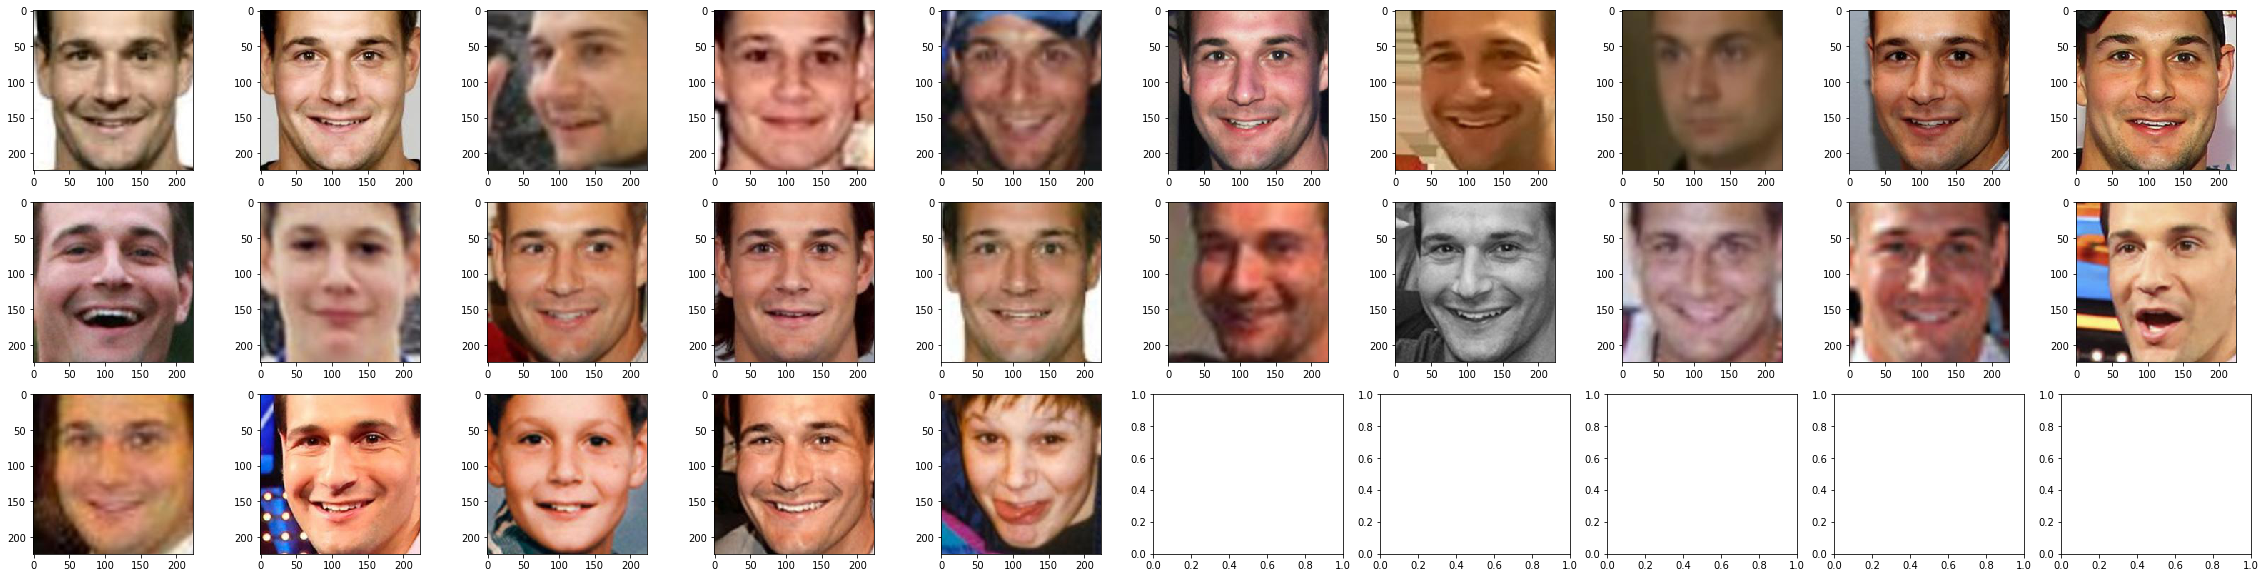

In [61]:
show_img('F0009/MID2')

In [62]:
files = [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser("../input/train")) for f in fn]
train_images_df = pd.DataFrame({
    'files': files,
    'familyId': [file.split('/')[3] for file in files],
    'kinId': [file.split('/')[4] for file in files],
    'uniqueId': [file.split('/')[3] + '/' + file.split('/')[4] for file in files]
})
train_images_df.head()

files familyId kinId    uniqueId
0  ../input/train/F0639/MID6/P06712_face1.jpg  F0639    MID6  F0639/MID6
1  ../input/train/F0639/MID1/P06711_face3.jpg  F0639    MID1  F0639/MID1
2  ../input/train/F0639/MID7/P11307_face4.jpg  F0639    MID7  F0639/MID7
3  ../input/train/F0639/MID4/P06711_face5.jpg  F0639    MID4  F0639/MID4
4  ../input/train/F0639/MID3/P06712_face2.jpg  F0639    MID3  F0639/MID3

Some simple stats of the train image folder

In [63]:
print("Total number of members in the dataset: {0}".format(train_images_df["uniqueId"].nunique()))
print("Total number of families in the dataset: {0}".format(train_images_df["familyId"].nunique()))

Total number of members in the dataset: 2316
Total number of families in the dataset: 470


In [64]:
family_with_most_pic = train_images_df["familyId"].value_counts()
kin_with_most_pic = train_images_df["uniqueId"].value_counts()
print("Family with maximum number of images: {0}, Image Count: {1}".format(family_with_most_pic.index[0], family_with_most_pic[0]))
print("Member with maximum number of images: {0}, Image Count: {1}".format(kin_with_most_pic.index[0], kin_with_most_pic[0]))

Family with maximum number of images: F0601, Image Count: 776
Member with maximum number of images: F0601/MID6, Image Count: 95


In [65]:
family_series = family_with_most_pic[:25]
labels = (np.array(family_series.index))
sizes = (np.array((family_series / family_with_most_pic.sum()) * 100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(title='Pic Count by Families')
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Families')

30% of train data comes frm a single family(British Royal Family). THis will cause some bias.

In [66]:
family_with_most_members = train_images_df.groupby("familyId")["kinId"].nunique().sort_values(ascending=False)
print("Family with maximum number of members: {0}, Member Count: {1}".format(family_with_most_members.index[0], family_with_most_members[0]))
print("Family with least number of members: {0}, Member Count: {1}".format(
    family_with_most_members.index[len(family_with_most_members)-1], 
    family_with_most_members[len(family_with_most_members)-1]))

Family with maximum number of members: F0601, Member Count: 41
Family with least number of members: F0275, Member Count: 1


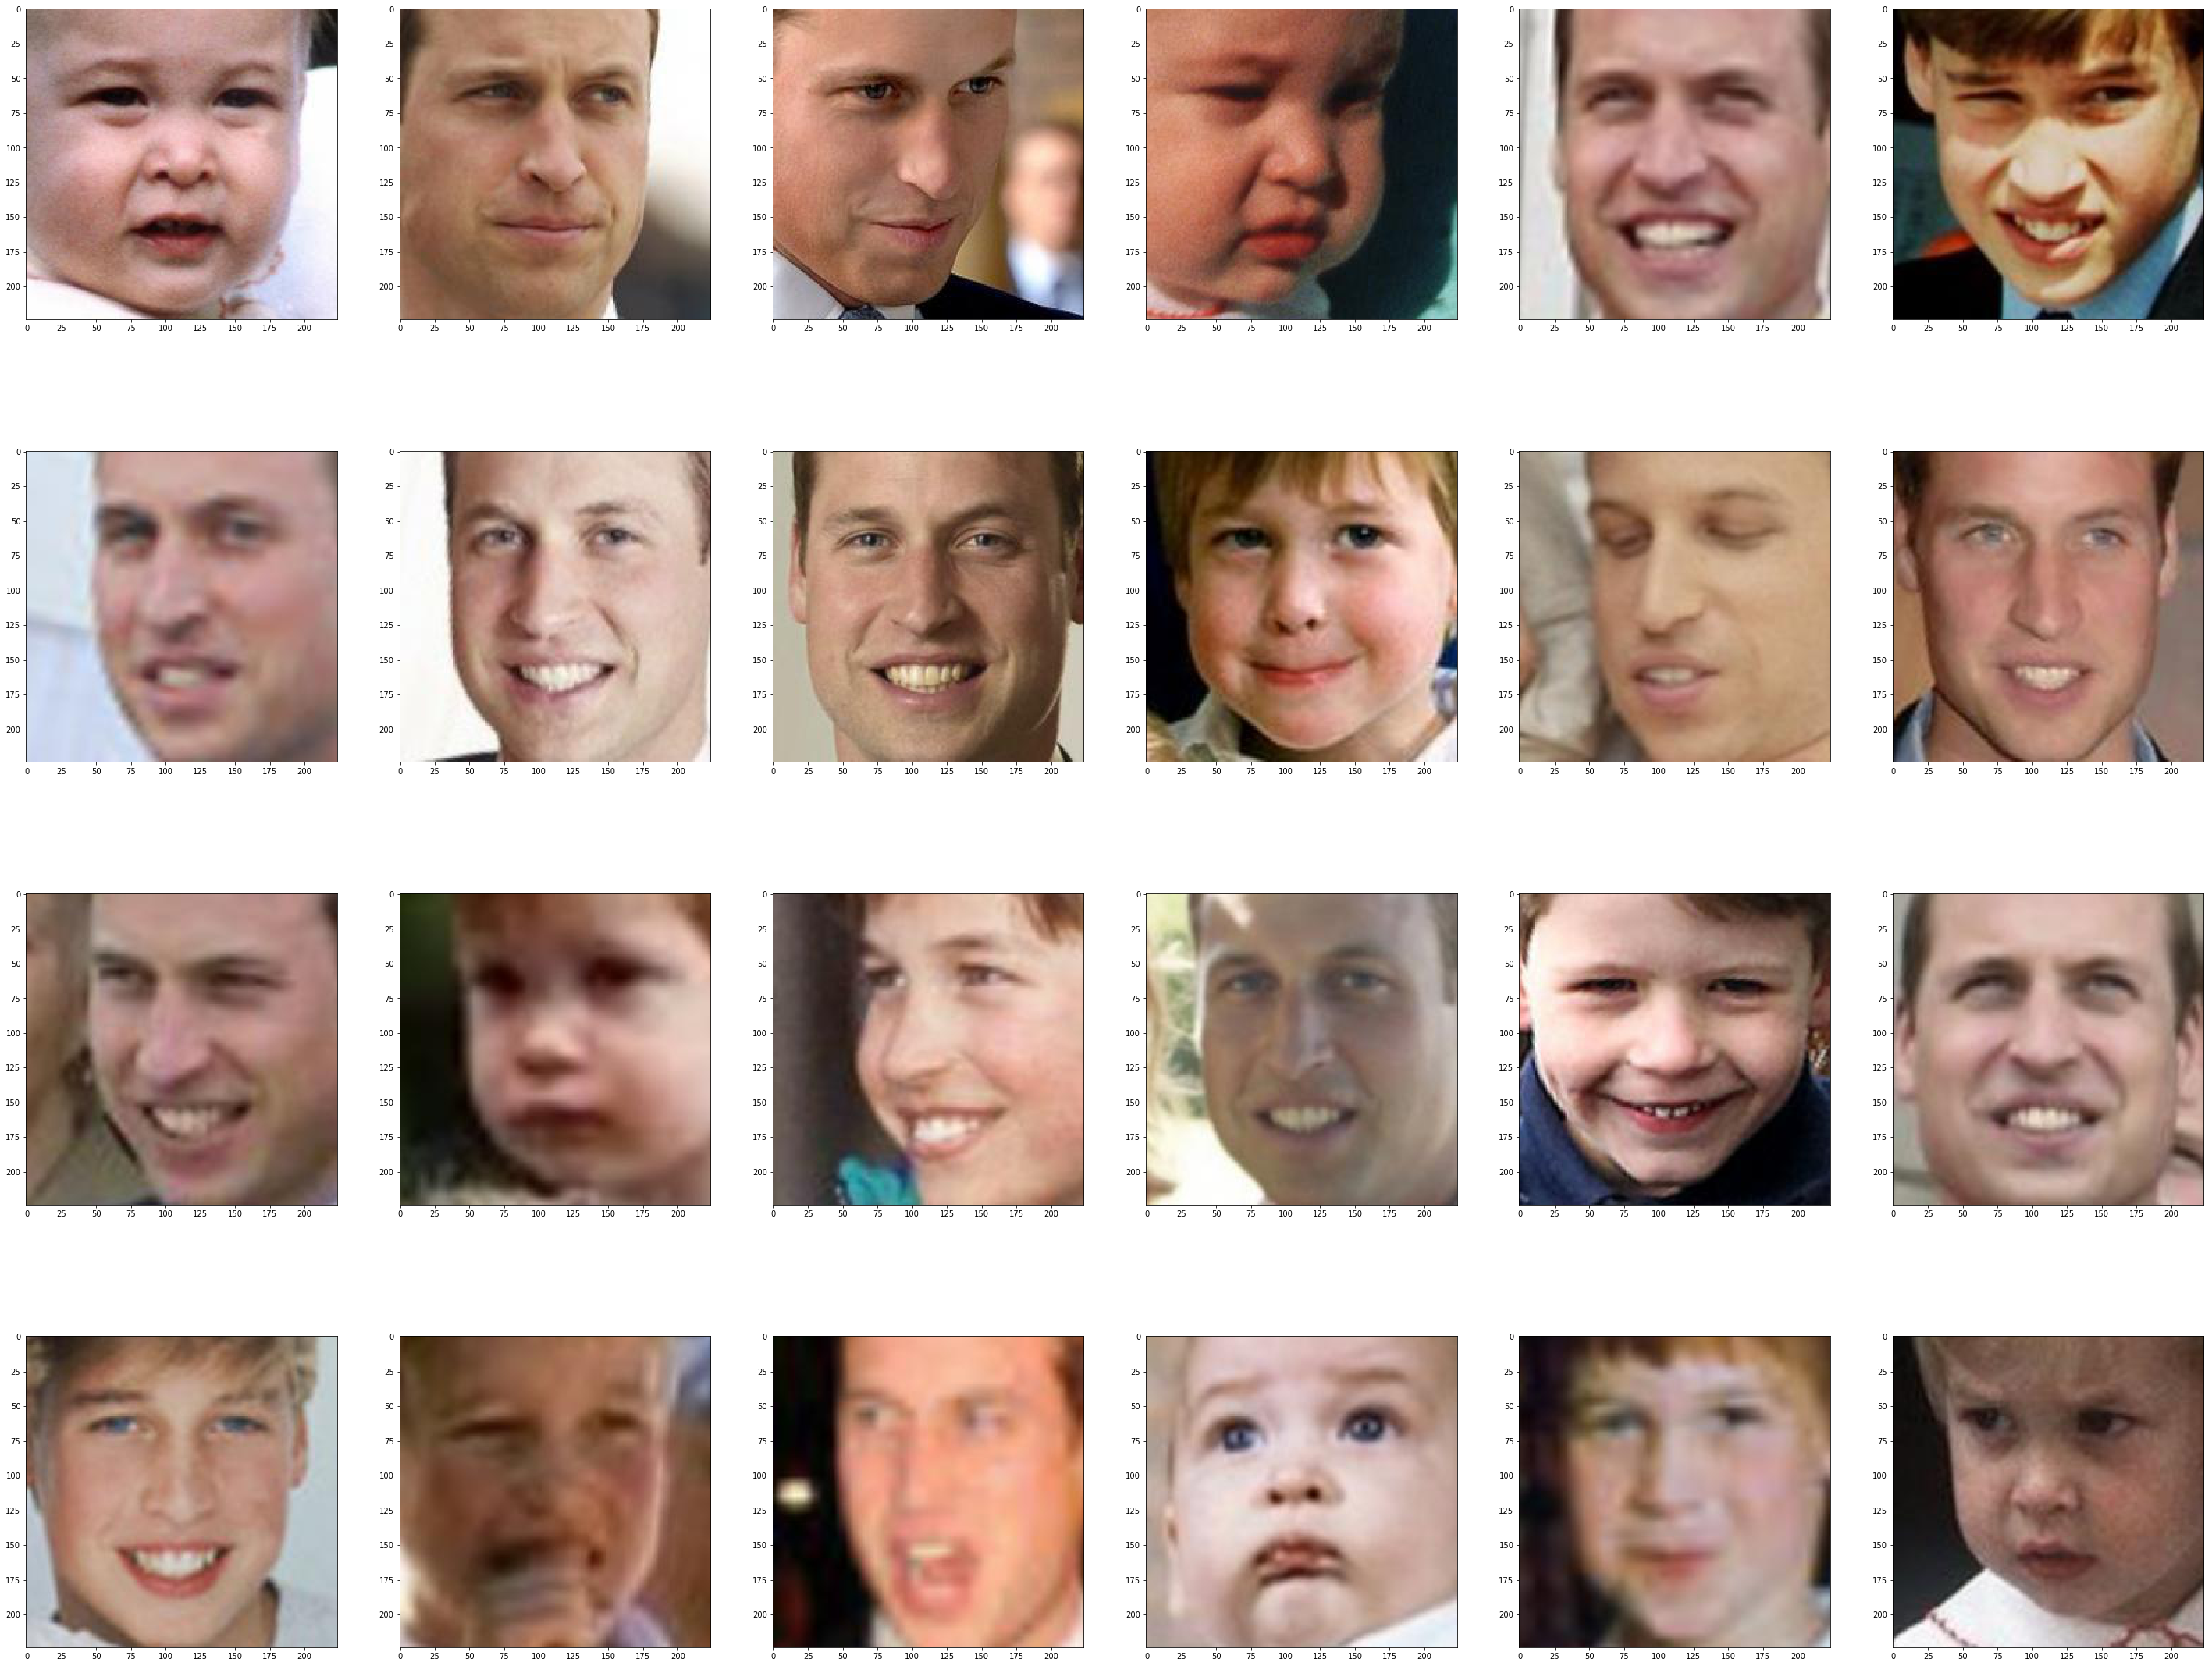

In [67]:
most_pic_members = train_images_df[train_images_df["uniqueId"] == kin_with_most_pic.index[0]].files.values
fig, ax = plt.subplots(4, 6, figsize=(50, 40))
row = 0
col = 0
for index in range(len(most_pic_members[:24])):
    with open(most_pic_members[index], 'rb') as f:
        img = Image.open(f)
        ax[row][col].imshow(img)

        if(col < 5):
            col = col + 1
        else: 
            col = 0
            row = row + 1
fig.show()

Images of british royal family

**2. Prediction with one-shot learning**

The solution will be based on pretrained image encoders using the below settings :

Pretraining on VGGFACE2 : A data-set of 3.3 million face images and 9000+ identities in a a wide range of different ethnicities, accents, professions and ages.
Pretraining techniques are useful because they allow us to transfer representations learned on a source task ( here image classification or regression ) into a target task which is kinship prediction in this case.
This helps reduce over-fitting and achieve a much faster convergence rate, especially if the source task and target task are somewhat close.

In [68]:
!pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-pubvalpj
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-pubvalpj
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8311 sha256=f9201b3da97adc2ca049dcd1ebe0446b85946065f5df3726033edaacce868949
  Stored in directory: /tmp/pip-ephem-wheel-cache-3pyw83qg/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


C

In [69]:
from collections import defaultdict
from glob import glob
from random import choice, sample
import cv2

In [70]:
train_file_path = "../input/train_relationships.csv"
train_folders_path = "../input/train/"
val_famillies = "F09"

In [71]:
all_images = glob(train_folders_path + "*/*/*.jpg")
train_images = [x for x in all_images if val_famillies not in x]
val_images = [x for x in all_images if val_famillies in x]

In [72]:
train_person_to_images_map = defaultdict(list)
ppl = [x.split("/")[-3] + "/" + x.split("/")[-2] for x in all_images]

for x in train_images:
    train_person_to_images_map[x.split("/")[-3] + "/" + x.split("/")[-2]].append(x)

val_person_to_images_map = defaultdict(list)

for x in val_images:
    val_person_to_images_map[x.split("/")[-3] + "/" + x.split("/")[-2]].append(x)

In [73]:
relationships = pd.read_csv(train_file_path)
relationships = list(zip(relationships.p1.values, relationships.p2.values))
relationships = [x for x in relationships if x[0] in ppl and x[1] in ppl]

In [74]:
train = [x for x in relationships if val_famillies not in x[0]]
val = [x for x in relationships if val_famillies in x[0]]

In [75]:
def read_img(path):
    img = image.load_img(path, target_size=(197, 197))
    img = np.array(img).astype(np.float)
    return preprocess_input(img, version=2)

In [76]:
def gen(list_tuples, person_to_images_map, batch_size=16):
    ppl = list(person_to_images_map.keys())
    while True:
        batch_tuples = sample(list_tuples, batch_size // 2)
        labels = [1] * len(batch_tuples)
        while len(batch_tuples) < batch_size:
            p1 = choice(ppl)
            p2 = choice(ppl)

            if p1 != p2 and (p1, p2) not in list_tuples and (p2, p1) not in list_tuples:
                batch_tuples.append((p1, p2))
                labels.append(0)

        for x in batch_tuples:
            if not len(person_to_images_map[x[0]]):
                print(x[0])

        X1 = [choice(person_to_images_map[x[0]]) for x in batch_tuples]
        X1 = np.array([read_img(x) for x in X1])

        X2 = [choice(person_to_images_map[x[1]]) for x in batch_tuples]
        X2 = np.array([read_img(x) for x in X2])

        yield [X1, X2], labels

   



In [77]:
IMG_DIM = (197,197,3)

In [78]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from keras.layers import Input, Dense, Flatten, GlobalMaxPool2D, GlobalAvgPool2D,MaxPooling1D,GlobalAveragePooling1D
from keras.layers import Concatenate, Multiply, Dropout, Subtract, Add, Conv2D,Conv1D
from keras.models import Model
from keras.layers import BatchNormalization,Reshape
from keras.preprocessing import image
from keras.optimizers import Adam,SGD,rmsprop
import h5py
from keras.losses import binary_crossentropy
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from keras.layers import LeakyReLU
from keras import regularizers

def auc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)


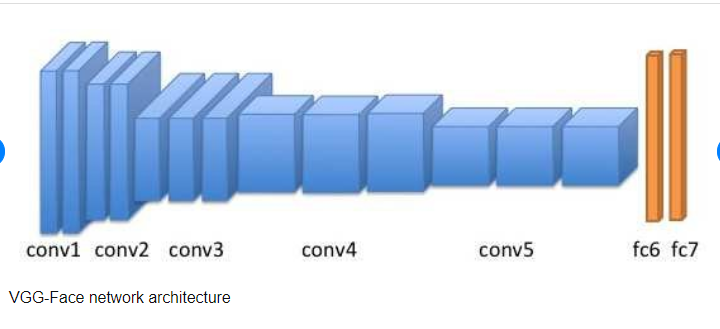

In [79]:
def siamese_model():
    input_1 = Input(shape=(197, 197, 3))
    input_2 = Input(shape=(197, 197, 3))

    base_model = VGGFace(model='resnet50', include_top=False)

    for x in base_model.layers[:-3]:
        x.trainable = True

    x1 = base_model(input_1)
    x2 = base_model(input_2)

    x1 = Concatenate(axis=-1)([GlobalAvgPool2D()(x1), GlobalAvgPool2D()(x1)])
    x2 = Concatenate(axis=-1)([GlobalMaxPool2D()(x2), GlobalAvgPool2D()(x2)])
    x3 = Subtract()([x1, x2])
    x3 = Multiply()([x3, x3])  
    x1_ = Multiply()([x1, x1])
    x2_ = Multiply()([x2, x2])
    x4  = Subtract()([x1_, x2_])    
    x   = Concatenate(axis=-1)([x4, x3])
    x   = Reshape(input_shape=(8192,), target_shape=(8192, 1))(x)
    
    x   = Conv1D(filters=128, kernel_size=10 ,strides=10,input_shape=( 8192,1),kernel_initializer= 'uniform',      
                  activation= 'relu')(x)
    x   = Conv1D( 128,3,activation= 'relu')(x)
    x   = Conv1D( 64,3,activation= 'relu')(x)
    x   = Conv1D( 64,3,activation= 'relu')(x)
    x   = Dropout(0.2)(x)
    x   = Flatten()(x)


    out = Dense(1, activation="sigmoid")(x)
    
    model = Model([input_1, input_2], out)
    model.compile(loss="binary_crossentropy", metrics=['acc',auc], optimizer=Adam(0.00001))
    model.summary()
    
    return model


In [80]:
from keras_vggface.utils import preprocess_input
from keras_vggface.vggface import VGGFace

In [81]:
file_path = "vgg_face.h5"

model_checkpoint = ModelCheckpoint(file_path, monitor='val_auc', verbose=1, 
                             save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, 
                          patience=30, verbose=0, mode='auto')
reducelr = ReduceLROnPlateau(monitor="val_loss", mode="max", factor=0.2, 
                                      patience=10, verbose=1)

In [82]:
callbacks_list = [reducelr, model_checkpoint,early_stopping]

In [83]:
import gc
import psutil
print("available RAM:", psutil.virtual_memory())
gc.collect()
print("available RAM:", psutil.virtual_memory())

available RAM: svmem(total=16831692800, available=12008030208, percent=28.7, used=4176658432, free=2884435968, active=5244600320, inactive=8092876800, buffers=515145728, cached=9255452672, shared=300552192, slab=372891648)
available RAM: svmem(total=16831692800, available=12036935680, percent=28.5, used=4147826688, free=2913267712, active=5215477760, inactive=8092909568, buffers=515170304, cached=9255428096, shared=300552192, slab=372756480)


In [84]:
curr_model = siamese_model()
curr_model_hist=curr_model.fit_generator(gen(train, train_person_to_images_map, batch_size=16), 
                            use_multiprocessing=True,
                    validation_data=gen(val, val_person_to_images_map, batch_size=16), 
                            epochs=100,
                            verbose=1,workers = 4, 
                            callbacks=callbacks_list,
                            steps_per_epoch=200,
                            validation_steps=100)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 197, 197, 3)  0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 197, 197, 3)  0                                            
__________________________________________________________________________________________________
vggface_resnet50 (Model)        multiple             23561152    input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d_4 (Glo (None, 2048)         0           vggface_resnet50[1][0]           
__________

/opt/conda/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning:

Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.



Epoch 1/100
200/200 [==============================] - 85s 423ms/step - loss: 0.6838 - acc: 0.5516 - auc: 0.5836 - val_loss: 0.6625 - val_acc: 0.6062 - val_auc: 0.6559

Epoch 00001: val_auc improved from -inf to 0.65594, saving model to vgg_face.h5
Epoch 2/100
200/200 [==============================] - 57s 286ms/step - loss: 0.6263 - acc: 0.6531 - auc: 0.7065 - val_loss: 0.6025 - val_acc: 0.6856 - val_auc: 0.7344

Epoch 00002: val_auc improved from 0.65594 to 0.73438, saving model to vgg_face.h5
Epoch 3/100
200/200 [==============================] - 57s 285ms/step - loss: 0.5857 - acc: 0.6922 - auc: 0.7455 - val_loss: 0.5423 - val_acc: 0.7425 - val_auc: 0.7980

Epoch 00003: val_auc improved from 0.73438 to 0.79797, saving model to vgg_face.h5
Epoch 4/100
200/200 [==============================] - 57s 285ms/step - loss: 0.5484 - acc: 0.7131 - auc: 0.7909 - val_loss: 0.5326 - val_acc: 0.7306 - val_auc: 0.8031

Epoch 00004: val_auc improved from 0.79797 to 0.80312, saving model to vgg_fac


Epoch 00035: val_auc did not improve from 0.89891
Epoch 36/100
200/200 [==============================] - 57s 287ms/step - loss: 0.3380 - acc: 0.8466 - auc: 0.9277 - val_loss: 0.4233 - val_acc: 0.8100 - val_auc: 0.8912

Epoch 00036: val_auc did not improve from 0.89891
Epoch 37/100
200/200 [==============================] - 58s 292ms/step - loss: 0.3253 - acc: 0.8544 - auc: 0.9358 - val_loss: 0.4202 - val_acc: 0.8175 - val_auc: 0.8898

Epoch 00037: val_auc did not improve from 0.89891
Epoch 38/100
200/200 [==============================] - 57s 287ms/step - loss: 0.3307 - acc: 0.8566 - auc: 0.9295 - val_loss: 0.4397 - val_acc: 0.8044 - val_auc: 0.8831

Epoch 00038: val_auc did not improve from 0.89891
Epoch 39/100
200/200 [==============================] - 58s 288ms/step - loss: 0.3246 - acc: 0.8603 - auc: 0.9339 - val_loss: 0.4152 - val_acc: 0.8187 - val_auc: 0.8902

Epoch 00039: val_auc did not improve from 0.89891
Epoch 40/100
200/200 [==============================] - 58s 289ms/ste

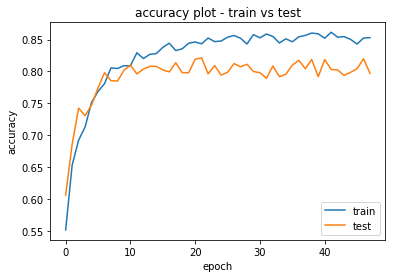

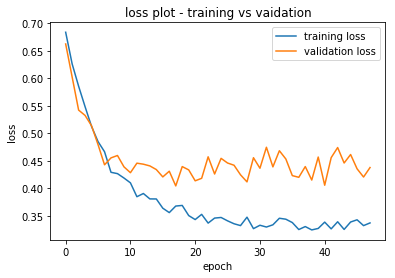

In [85]:
import matplotlib.pyplot as plt
def plot_accuracy(y):
    if(y == True):
        plt.plot(curr_model_hist.history['acc'])
        plt.plot(curr_model_hist.history['val_acc'])
        plt.legend(['train', 'test'], loc='lower right')
        plt.title('accuracy plot - train vs test')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.show()
    else:
        pass
    return

def plot_loss(y):
    if(y == True):
        plt.plot(curr_model_hist.history['loss'])
        plt.plot(curr_model_hist.history['val_loss'])
        plt.legend(['training loss', 'validation loss'], loc = 'upper right')
        plt.title('loss plot - training vs vaidation')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()
    else:
        pass
    return


plot_accuracy(True)
plot_loss(True)

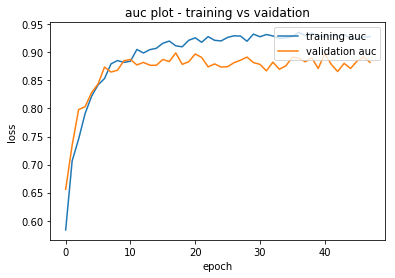

In [86]:
def plot_auc(y):
    if(y == True):
        plt.plot(curr_model_hist.history['auc'])
        plt.plot(curr_model_hist.history['val_auc'])
        plt.legend(['training auc', 'validation auc'], loc = 'upper right')
        plt.title('auc plot - training vs vaidation')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()
    else:
        pass
    return


plot_auc(True)

In [87]:
test_path = "../input/test/"

In [88]:
def chunker(seq, size=32):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))


from tqdm import tqdm

submission = pd.read_csv('../input/sample_submission.csv')

predictions = []

for batch in tqdm(chunker(submission.img_pair.values)):
    X1 = [x.split("-")[0] for x in batch]
    X1 = np.array([read_img(test_path + x) for x in X1])

    X2 = [x.split("-")[1] for x in batch]
    X2 = np.array([read_img(test_path + x) for x in X2])

    pred = curr_model.predict([X1, X2]).ravel().tolist()
    predictions += pred

submission['is_related'] = predictions

submission.to_csv("vgg_face.csv", index=False)

166it [00:54,  3.44it/s]


Conclusion:-

 As advised to use ConV1d , inplace of Dense, I was used several ConV1d with and alone with Dense Network, but the max AUC , i could achieve with test data was 
0.886, from 0.866.